In [1]:
using Revise
using DifferentialEquations
using Thyrosim
using DiffEqCallbacks
using DiffEqParamEstim
using Statistics
using Plots
using DelimitedFiles
using DataFrames
using ProgressMeter
using StatsPlots
using BenchmarkTools

# What is the fastest ODE solver in Julia for Thyrosim?

[Here](https://diffeq.sciml.ai/v2.0/solvers/ode_solve.html) is a list of methods available. Let us try a few on Blakesley's data.

### Some setup code

+ Import data
+ Import current Thyrosim model
+ define some helper functions

In [2]:
# import data
my_time, my400_data, my450_data, my600_data = blakesley_data()
blakesley_tspan = (my_time[1], my_time[end])
                                      
# current model being fitted
fitting_index =
    [1; 13;                  # S4, VtshMax
    30; 31;                  # A0, B0
    49; 50; 51; 52; 53; 54;  # hill function parameters
    68]                      # reference BMI
initial_guess = [0.00233909723258862, 0.01888250414072272, 70.34130520454524, 
    37.31550895469677, 4.534828778029588, 4.418055548810554, 9.289765460633825, 
    7.063722129732839, 6.800716242585794, 15.653958585100927, 22.5]
train_minimizer = [0.002282360524823213, 0.011016677369316172, 89.38744105298555, 46.97122027114195, 
    1.5724372989233657, 3.2917606928323795, 4.121893676559527, 6.470564723559839, 5.328696916177691, 
    24.315495224986865, 24.053313990813447]

# gives 400/450/600 mcg of oral T4 at hour 24
function blakesley_condition(u, t, integrator)
    return t - 24.0
end

# define function for adding dose
function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end
                                                                        
# setup ODE
sex = false # 1 = male, 0 = female
bmi = train_minimizer[end]
h = sex ? 1.77 : 1.63
w = bmi * h^2
println("h = $h, w = $w")
cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
ic, p = initialize([1.0; 0.88; 1.0; 0.88], true, h, w, sex, 
    fitting_index=fitting_index, p_being_optimized=train_minimizer) 
p[fitting_index] = train_minimizer

h = 1.63, w = 63.907249942192244


11-element Array{Float64,1}:
  0.002282360524823213
  0.011016677369316172
 89.38744105298555
 46.97122027114195
  1.5724372989233657
  3.2917606928323795
  4.121893676559527
  6.470564723559839
  5.328696916177691
 24.315495224986865
 24.053313990813447

# Timings for different solvers

In [3]:
# default
T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
@btime sol400 = solve(prob400);

  3.794 ms (20406 allocations: 927.16 KiB)


In [4]:
# BS3 (aka ode23, for fast solving at lower tolerance)
T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
@btime sol400 = solve(prob400, BS3());

  1.258 ms (5901 allocations: 693.33 KiB)


In [5]:
# Tsit5 (more efficient ode 45, recommended for non-stiff ODEs)
T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
@btime sol400 = solve(prob400, Tsit5());

  1.521 ms (6878 allocations: 1.12 MiB)


In [6]:
# Vern7 (more efficient ode113 and dop853)
T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
@btime sol400 = solve(prob400, Vern7());

  2.158 ms (11566 allocations: 2.32 MiB)


In [7]:
# RK4 (Runge-Kutta Order 4 method)
T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
@btime sol400 = solve(prob400, RK4());

  1.506 ms (5357 allocations: 632.58 KiB)


### Check plots

h = 1.63, w = 63.907249942192244


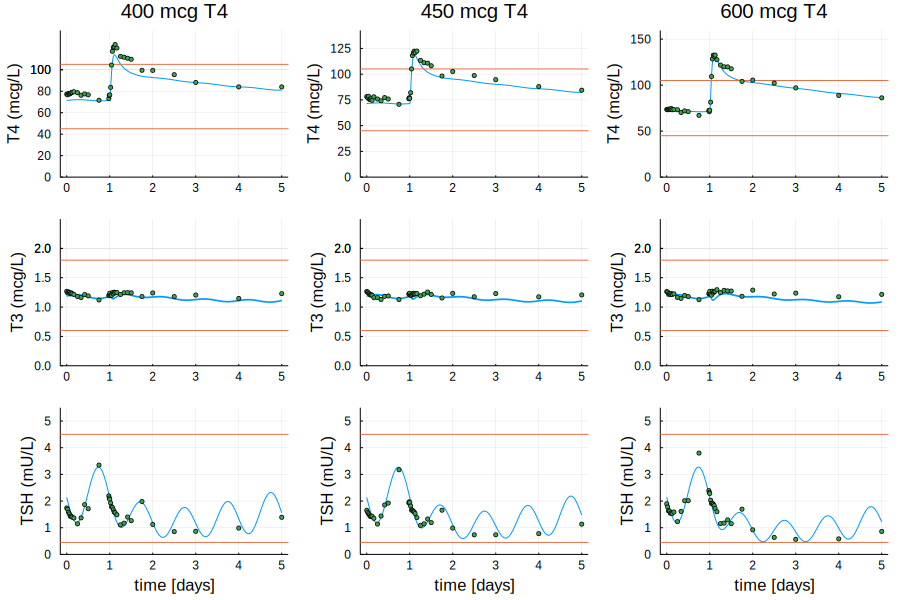

In [11]:
sex = false # 1 = male, 0 = female
bmi = train_minimizer[end]
h = sex ? 1.77 : 1.63
w = bmi * h^2
println("h = $h, w = $w")
cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
ic, p = initialize([1.0; 0.88; 1.0; 0.88], true, h, w, sex, 
    fitting_index=fitting_index, p_being_optimized=train_minimizer) 
p[fitting_index] = train_minimizer

#400 T4
T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol400 = solve(prob400, BS3())
a = plot_blakesley(sol400, "400", title="400 mcg T4")

# 450 T4
T4_init_450, T3_init_450, TSH_init_450 = my450_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 450 / 777.0
prob450 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol450 = solve(prob450, BS3())
b = plot_blakesley(sol450, "450", title="450 mcg T4")

#600 T4
T4_init_600, T3_init_600, TSH_init_600 = my600_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 600 / 777.0
prob600 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol600 = solve(prob600, BS3())
c = plot_blakesley(sol600, "600", title="600 mcg T4")

blakesley_plot = plot(a, b, c, layout=(1, 3), size=(900, 600))

**Conclusion:** 
+ BS3 seems to be the fastest
+ Tsit5 and RK4 are close competitors

All method gives reasonable Thyrosim predictions on Blakesley data. 